# **Modelling and Evaluating - RGB**

## Objectives
To develop, train, and evaluate a machine learning model for image classification, incorporating image augmentation and comprehensive performance analysis through various metrics and visualizations. The objective includes modifying class indices, plotting augmented images, creating and summarizing the model, and saving the trained model. Model performance will be assessed using accuracy, ROC curves, and classification reports, followed by plotting the confusion matrix and saving the evaluation results. The final output will also involve making predictions on a random image file.

## Inputs
* Images are taken from the test, train, validation folders and their subfolders.
```
└───inputs/ 
    └───potato_disease_dataset/ 
        ├───test/
        │   ├───healthy
        │   ├───early_blight
        │   └───late_blight                   
        ├───train/
        │   ├───healthy
        │   ├───early_blight
        │   └───late_blight          
        └───validation/
            ├───healthy
            ├───early_blight
            └───late_blight               
```
* Image shape embeddings.


## Outputs
- Image augmentation.
    - Plot augmented images for each dataset.
- Modify class indices to alter prediction in labels.
- Create a machine learning model and display its summary.
    - Train the model.
    - Save the model.
    - Plot the learning curve to show model performance.
        - Model A - generate separate plots for accuracy and loss.
        - Model B - create a comprehensive model history plot.
        - Model C - visualize model history using Plotly.
- Evaluate the model using a saved file.
    - Calculate accuracy.
    - Plot the ROC curve.
    - Generate a general classification report.
    - Generate a classification report including macro average and weighted average.
    - Plot the confusion matrix.
    - Save the evaluation results in a pickle file.
- Predict on a random image file.

---

## Import necessary packages for this notebook

In [49]:
# Operating system functionality
import os
import pathlib

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Machine learning and deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

# Model persistence
import joblib

# Scikit-learn for evaluation metrics
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc, roc_auc_score

# Inline plotting for Jupyter notebooks
%matplotlib inline

---

## Set Working Directory

As the notebooks are within a subfolder, we will need to change the working directory when running the notebook in the editor.

We need to change the working directory from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/ci-ms5-spudscan/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory.

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/ci-ms5-spudscan'

---

## Set input directory
Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/potato_disease_dataset'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

print("Train path:", train_path)
print("Validation path:", val_path)
print("Test path:", test_path)

Train path: inputs/potato_disease_dataset/train
Validation path: inputs/potato_disease_dataset/validation
Test path: inputs/potato_disease_dataset/test


---

## Set output directory

Change the version number below to change output dir.

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


---

## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


---

### Set image shape

In [8]:
# Import saved image shape embedding
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image data augmentation

### Initialize ImageDataGenerator

In [9]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Set Batch Size

In [10]:
batch_size = 16

### Augment datasets

#### Augment training image set

In [11]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1506 images belonging to 3 classes.


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

#### Augment validation image set

In [12]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 213 images belonging to 3 classes.


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

#### Augment test image set

In [13]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 433 images belonging to 3 classes.


{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

### Plot augmented datasets

In [14]:
# Function to plot augmented datasets
def plot_augmented_images(dataset, title):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            img, label = dataset.next()
            print(img.shape)
            axes[i, j].imshow(img[0])
            axes[i, j].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### Plot augmented training image set

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


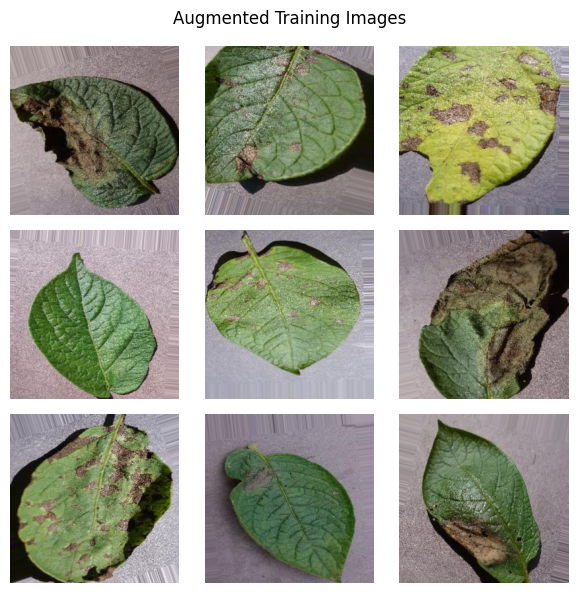

In [15]:
# Plot augmented training image set
plot_augmented_images(train_set, "Augmented Training Images")

#### Plot augmented validation image set

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


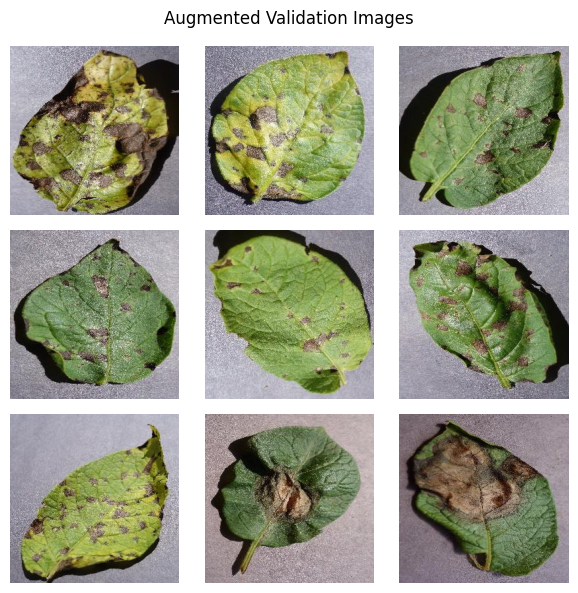

In [16]:
# Plot augmented validation image set
plot_augmented_images(validation_set, "Augmented Validation Images")

### Plot augmented test image set

(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)
(16, 256, 256, 3)


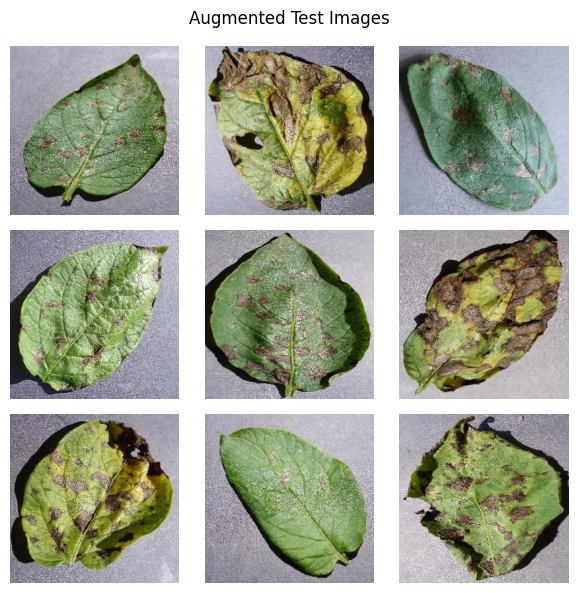

In [17]:
# Plot augmented test image set
plot_augmented_images(test_set, "Augmented Test Images")

### Save class indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

### Define the CNN Model

In [19]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Flatten the layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for potato leaf diseases

# Summary of the custom model
model.summary()

2024-06-27 08:21:42.954619: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

### Compile the model

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Callbbacks

In [21]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define model checkpoint callback
checkpoint = ModelCheckpoint(f"{file_path}/best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

### Train the model

In [22]:
model.fit(
        train_set,
        epochs=50,
        validation_data=validation_set,
        callbacks=[early_stopping, checkpoint])

2024-06-27 08:21:43.551689: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
95/95 [==============================] - 203s 2s/step - loss: 0.7149 - accuracy: 0.7191 - val_loss: 1.8582 - val_accuracy: 0.4648
Epoch 2/50
95/95 [==============================] - 200s 2s/step - loss: 0.5304 - accuracy: 0.7915 - val_loss: 3.6467 - val_accuracy: 0.4648
Epoch 3/50
95/95 [==============================] - 199s 2s/step - loss: 0.4188 - accuracy: 0.8572 - val_loss: 3.3787 - val_accuracy: 0.4648
Epoch 4/50
95/95 [==============================] - 202s 2s/step - loss: 0.3866 - accuracy: 0.8612 - val_loss: 3.2397 - val_accuracy: 0.4648
Epoch 5/50
95/95 [==============================] - 196s 2s/step - loss: 0.3889 - accuracy: 0.8586 - val_loss: 0.9993 - val_accuracy: 0.5634
Epoch 6/50
95/95 [==============================] - 196s 2s/step - loss: 0.3757 - accuracy: 0.8732 - val_loss: 0.3184 - val_accuracy: 0.8779
Epoch 7/50
95/95 [==============================] - 194s 2s/step - loss: 0.3854 - accuracy: 0.8718 - val_loss: 0.2275 - val_accuracy: 0.9249
Epoch 8/50
95

### Load saved best model

In [25]:
load_model(f"{file_path}/best_model.h5")

---

## Model Performance

### Model Learning Curve - A
This cell creates and saves plots of the training and validation loss and accuracy.

<Figure size 500x400 with 0 Axes>

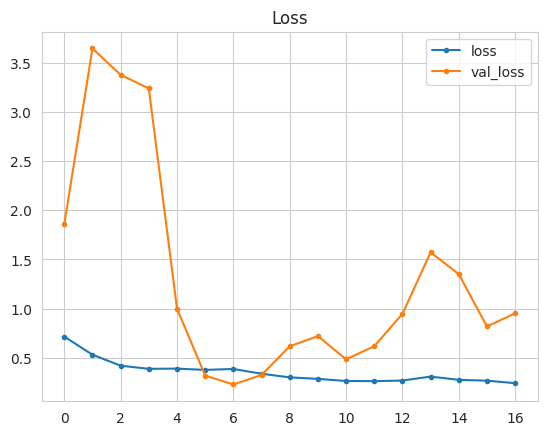

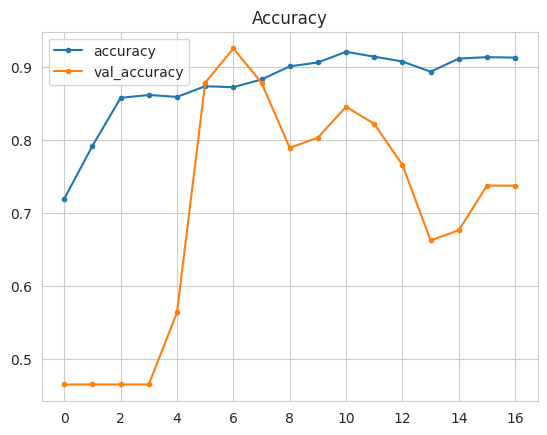

In [26]:
# Plotting training and validation loss
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

# Save the plot of training and validation loss
plt.savefig(f'{file_path}/curve_a_model_training_losses.png', bbox_inches='tight', dpi=150)

print("\n")

# Plotting training and validation accuracy
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

# Save the plot of training and validation accuracy
plt.savefig(f'{file_path}/curve_a_model_training_acc.png', bbox_inches='tight', dpi=150)

plt.show()

### Model Learning Curve - B
This cell generates and saves a single combined plot of all training and validation metrics.

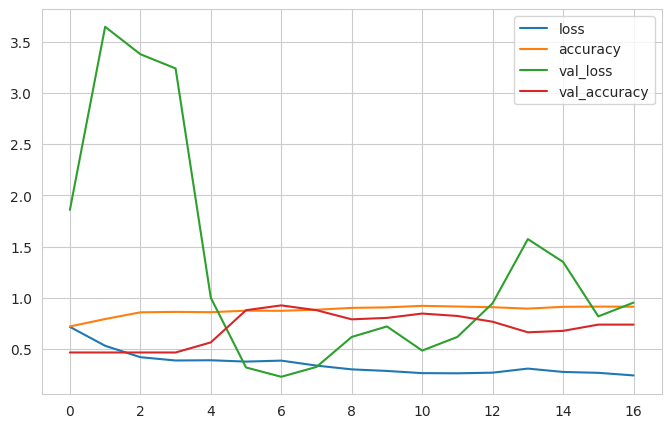

In [28]:
# Plotting training and validation metrics together
pd.DataFrame(model.history.history).plot(figsize=(8, 5))

# Save the combined plot of all training metrics
plt.savefig(f'{file_path}/curve_b_model_loss_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve - C

This cell creates an interactive plot with Plotly to show training and validation loss and accuracy on a dual y-axis, and saves the plot as an image.

In [31]:
# Create subplots with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add validation loss trace to the plot
fig.add_trace(
    go.Scatter(y=model.history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

# Add training loss trace to the plot
fig.add_trace(
    go.Scatter(y=model.history.history['loss'], name="loss"),
    secondary_y=False,
)

# Add validation accuracy trace to the plot
fig.add_trace(
    go.Scatter(y=model.history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

# Add training accuracy trace to the plot
fig.add_trace(
    go.Scatter(y=model.history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Update layout with title and axis labels
fig.update_layout(
    title_text="Loss/Accuracy of Model"
)

fig.update_xaxes(title_text="Epoch")

fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )

# Show the plot
fig.show()

---

## Model Evaluation

### Load saved model
Loads the trained and saved model from the specified file path.

In [32]:
best_model = load_model(f"{file_path}/best_model.h5")

### Evaluate the model on the test set

In [34]:
test_loss, test_accuracy = best_model.evaluate(test_set)
print(f"Test Accuracy: {test_accuracy}")

28/28 [==============================] - 12s 427ms/step - loss: 0.2464 - accuracy: 0.9215
Test Accuracy: 0.9214780330657959


### Calculate accuracy and generate predictions

Reset the test set iterator, calculates the true labels, and generates predictions for the test set.

In [36]:
# Reset the test set iterator
test_set.reset()

# Generate predictions
y_true = test_set.classes
y_pred = best_model.predict(test_set, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

28/28 [==============================] - 12s 442ms/step


### Generate classification report - A

Generates and prints a standard classification report.

In [39]:
report_a = classification_report(y_true, y_pred_classes, target_names=labels)
print("Classification Report for Model A:\n", report_a)

Classification Report for Model A:
                        precision    recall  f1-score   support

Potato___Early_blight       0.91      0.99      0.95       201
 Potato___Late_blight       0.99      0.85      0.91       201
     Potato___healthy       0.69      0.94      0.79        31

             accuracy                           0.92       433
            macro avg       0.86      0.93      0.89       433
         weighted avg       0.93      0.92      0.92       433



### Generate classification report - B

Generates a classification report and visualizes it as a heatmap

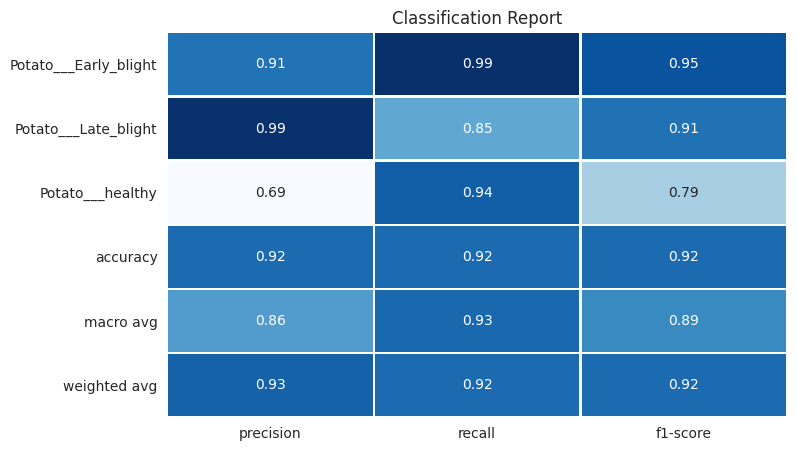

In [42]:
clf_report = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Blues", cbar=False, linewidths=1)
plt.title('Classification Report')
plt.savefig(f'{file_path}/classification_report_heatmap.png')
plt.show()